C:\Users\jemsc\AppData\Local\Temp\ipykernel_6848\3046933579.py:48: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()  # Changed to use Sampler instead of StatevectorSampler



Iris Dataset Results:
Classical SVM - Accuracy: 1.0000, Time: 0.0010 seconds
Quantum VQC - Accuracy: 0.5000, Total Time: 9.1027 seconds
  Quantum VQC Fit Time: 9.0302 seconds
  Quantum VQC Predict Time: 0.0705 seconds


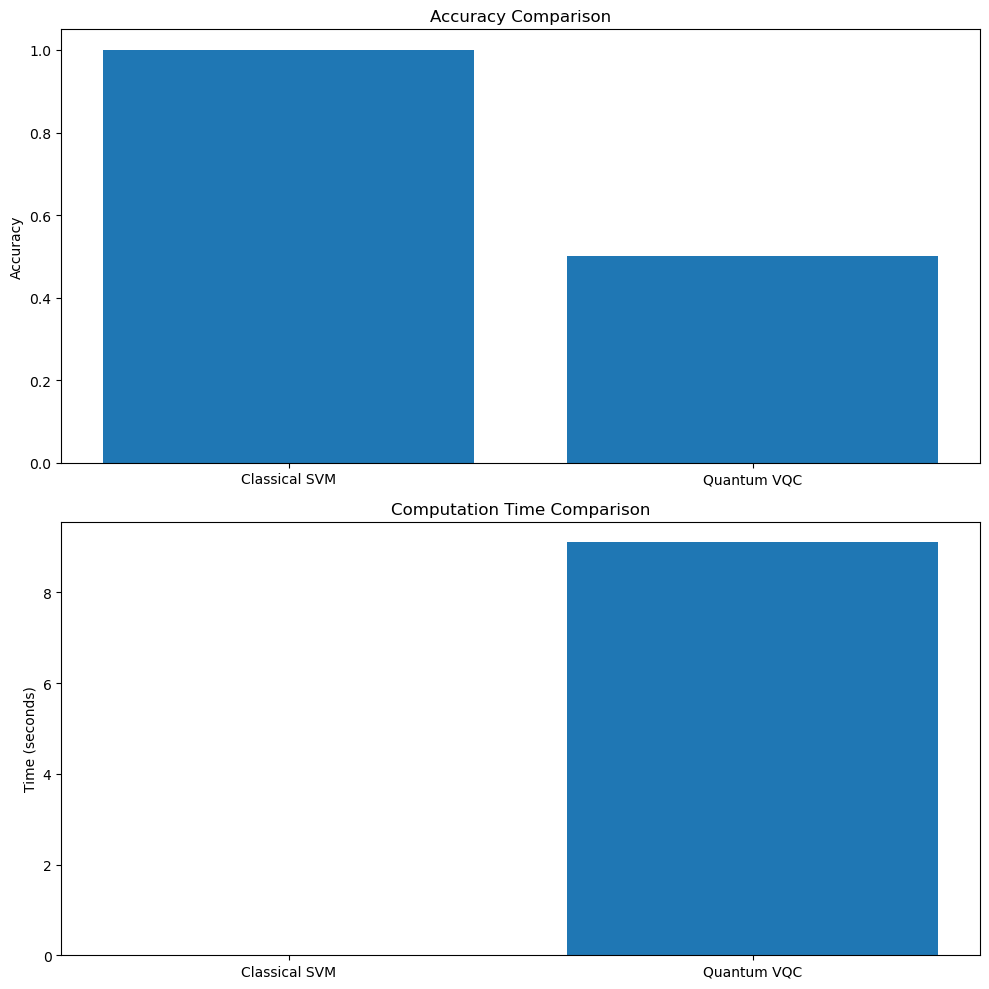

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from tqdm import tqdm

def prepare_binary_data(X, y):
    if len(np.unique(y)) > 2:
        # Keep only the first two classes for binary classification
        mask = y < 2
        X = X[mask]
        y = y[mask]
    return X, y

def run_experiment(X, y, dataset_name):
    # Prepare the data
    X, y = prepare_binary_data(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Classical SVM
    start_time_classical = time.time()
    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train, y_train)
    y_pred_classical = svm_classifier.predict(X_test)
    accuracy_classical = accuracy_score(y_test, y_pred_classical)
    time_classical = time.time() - start_time_classical

    # Quantum VQC
    num_qubits = min(5, X_train.shape[1])  # Adaptive number of qubits
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
    ansatz = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=2)

    backend = AerSimulator()
    sampler = Sampler()  # Changed to use Sampler instead of StatevectorSampler
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=COBYLA(maxiter=50),
        sampler=sampler
    )

    start_time_quantum = time.time()
    pca = PCA(n_components=num_qubits)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    vqc_fit_start = time.time()
    vqc.fit(X_train_pca, y_train)
    vqc_fit_time = time.time() - vqc_fit_start

    vqc_predict_start = time.time()
    y_pred_quantum = vqc.predict(X_test_pca)
    vqc_predict_time = time.time() - vqc_predict_start

    accuracy_quantum = accuracy_score(y_test, y_pred_quantum)
    time_quantum = time.time() - start_time_quantum

    return {
        'dataset': dataset_name,
        'classical_accuracy': accuracy_classical,
        'classical_time': time_classical,
        'quantum_accuracy': accuracy_quantum,
        'quantum_time': time_quantum,
        'quantum_fit_time': vqc_fit_time,
        'quantum_predict_time': vqc_predict_time
    }

# Load Iris dataset
iris = datasets.load_iris()
result = run_experiment(iris.data, iris.target, "Iris")

# Print results
print(f"\nIris Dataset Results:")
print(f"Classical SVM - Accuracy: {result['classical_accuracy']:.4f}, Time: {result['classical_time']:.4f} seconds")
print(f"Quantum VQC - Accuracy: {result['quantum_accuracy']:.4f}, Total Time: {result['quantum_time']:.4f} seconds")
print(f"  Quantum VQC Fit Time: {result['quantum_fit_time']:.4f} seconds")
print(f"  Quantum VQC Predict Time: {result['quantum_predict_time']:.4f} seconds")

# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Accuracy comparison
accuracies = [result['classical_accuracy'], result['quantum_accuracy']]
algorithms = ['Classical SVM', 'Quantum VQC']

ax1.bar(algorithms, accuracies)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')

# Time comparison
times = [result['classical_time'], result['quantum_time']]

ax2.bar(algorithms, times)
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Computation Time Comparison')

plt.tight_layout()
plt.show()